# Wykresy pomocnicze
W tym notatniku trzymam kod do generaowania różnych wykresów dla których nie mam prawdziwych danych a 
jedynie generuję sobie jakieś przykładowe

In [4]:
import numpy as np
import matplotlib.pyplot as plt

### Funkcje pomocnicze
Funkcje które przydają się w wielu przypadkach

In [6]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def generate_sampling(start_timestamp, end_timestamp, frequency):
    sample_count = (end_timestamp - start_timestamp) * frequency
    sampling = np.linspace(start_timestamp, end_timestamp, sample_count)
    return sampling

class Sinusoid:

    def __init__(self, amplitude, frequency, phase_shift, amplitude_shift):
        self.amplitude = amplitude
        self.frequency = frequency
        self.phase_shift = phase_shift
        self.amplitude_shift = amplitude_shift


    def generate_timeseries(self, sampling):        
        time_series = self.amplitude * np.sin(2*np.pi*self.frequency*sampling + self.phase_shift) + self.amplitude_shift
        return time_series

    @staticmethod
    def generate_random_sinusoid(amplitude, frequency, phase_shift, amplitude_shift):
        a = np.random.uniform(amplitude[0], amplitude[1])
        f = np.random.uniform(frequency[0], frequency[1])
        shift = np.random.uniform(amplitude_shift[0], amplitude_shift[1])
        phase = np.random.uniform(phase_shift[0], phase_shift[1])
        return Sinusoid(a, f, phase, shift)

    def to_json(self):
        return json.dumps(vars(self))


class Signal:

    def __init__(self, carrier, signals):
        self.carrier = carrier
        self.signals = signals

    def generate_timeseries(self, sampling):
        time_series = self.carrier.generate_timeseries(sampling)
        for signal in self.signals:
            time_series += signal.generate_timeseries(sampling)
        return time_series

    @staticmethod
    def generate_random_signal(amplitude, frequency, phase_shift, amplitude_shift, signal_count):
        carrier = Sinusoid(amplitude[1], frequency[0], 0, 0)
        signals = []
        for _ in range(signal_count):
            signals.append(Sinusoid.generate_random_sinusoid(amplitude, frequency, phase_shift, amplitude_shift))
        return Signal(carrier, signals)

    def to_json(self):
        contents = {'carrier':vars(self.carrier)}
        serialized_signals = []
        for signal in self.signals:
            serialized_signals.append(vars(signal))
        contents['signals'] = serialized_signals
        return json.dumps(contents)

### Przykłady błędów zegara
Na tym wykresie mamy trzy przykłady błędów zegara:
 - stały
 - deterministyczny
 - mieszany (deterministyczny + stochastyczny)

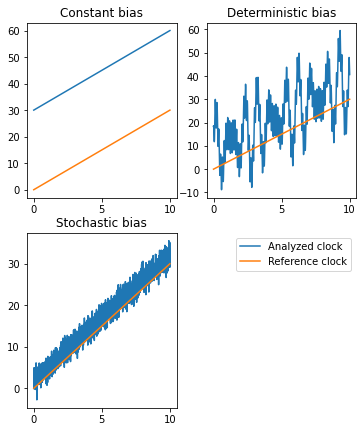

In [34]:
i = generate_sampling(0,10,300)

delta_T_ref = 3
T_ref = i * delta_T_ref
T_const = T_ref + 30

deterministic_noise = Signal.generate_random_signal((5,10),(1,10),(0,3),(0,10),2)
T_det = T_ref + deterministic_noise.generate_timeseries(i)

fig = plt.figure(figsize=cm2inch(15, 18))
fig.tight_layout(pad=0.8, h_pad=2)
fig.patch.set_facecolor('white')
skip = 0

white_noise = np.random.normal(0.0, 1.0, size=len(i)) + np.random.normal(2.0, 1.0, size=len(i))
T_st = T_ref + white_noise

ax = fig.add_subplot(2, 2, 1)
ax.title.set_text('Constant bias')
ax.plot(i, T_const)
ax.plot(i, T_ref)


ax = fig.add_subplot(2, 2, 2)
ax.title.set_text('Deterministic bias')
ax.plot(i, T_det)
ax.plot(i, T_ref)

ax = fig.add_subplot(2, 2, 3)
ax.title.set_text('Stochastic bias')
ax.plot(i, T_st)
ax.plot(i, T_ref)

ax = fig.add_subplot(2, 2, 4)
ax.plot([], [], label='Analyzed clock')
ax.plot([], [], label='Reference clock')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
ax.legend()
plt.show()